Initial data cleaning & exploration for house price prediction

In [103]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy  as np
import pandas as pd
import pickle
import scipy.stats as ss
from statsmodels.graphics.gofplots import qqplot
plt.style.use('ggplot')

In [104]:
pd.__version__

'0.23.4'

In [112]:
import xgboost

In [105]:
with open('basecase/train.pickle', 'rb') as f:
    X, Xd, y, X_le = pickle.load(f)
    
with open('basecase/test.pickle', 'rb') as f:
    Xt, Xdt, yt, X_le = pickle.load(f)

xy = pd.concat([X,y], axis = 1)
xyt = pd.concat([Xt,yt], axis = 1)

In [106]:
X.columns

Index(['MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape',
       'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood',
       'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageFinish',
       'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'Po

In [108]:
X[['TotalBsmtSF','1stFlrSF','GrLivArea']].corr()

,TotalBsmtSF,1stFlrSF,GrLivArea
TotalBsmtSF,1.000000,0.803830,0.408793
1stFlrSF,0.803830,1.000000,0.533697
GrLivArea,0.408793,0.533697,1.000000


In [52]:
X.dtypes

MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
Alley             object
LotShape          object
LandContour       object
Utilities         object
LotConfig         object
LandSlope         object
Neighborhood      object
BldgType          object
HouseStyle        object
OverallQual        int64
OverallCond        int64
RoofStyle         object
RoofMatl          object
Exterior1st       object
Exterior2nd       object
MasVnrType        object
MasVnrArea       float64
ExterQual         object
ExterCond         object
Foundation        object
BsmtQual          object
BsmtCond          object
BsmtExposure      object
BsmtFinType1      object
BsmtFinSF1         int64
BsmtFinType2      object
                  ...   
GarageFinish      object
GarageCars         int64
GarageArea         int64
GarageQual        object
GarageCond        object
PavedDrive        object
WoodDeckSF         int64
OpenPorchSF        int64
EnclosedPorch      int64


In [53]:
X.PoolQC.value_counts()/X.shape[0]

0    0.995885
1    0.004115
Name: PoolQC, dtype: float64

In [54]:
c0 = 0.95
for var in X.columns:
    if X[var].dtype == object:
        if X[var].value_counts()[0]/X.shape[0] > c0:
            print(var, '\n', X[var].value_counts()/X.shape[0], '\n')
# delete Street, Utilities, PoolQC, PoolArea
# change RoofMatl to CompShg / Other
# check MasVnrType

Street 
 Pave    0.995885
Grvl    0.004115
Name: Street, dtype: float64 

Utilities 
 AllPub    0.999314
NoSeWa    0.000686
Name: Utilities, dtype: float64 

RoofMatl 
 CompShg    0.982853
Tar&Grv    0.007545
WdShngl    0.004115
WdShake    0.003429
Membran    0.000686
Roll       0.000686
Metal      0.000686
Name: RoofMatl, dtype: float64 

Heating 
 GasA     0.978052
GasW     0.012346
Grav     0.004801
Wall     0.002743
OthW     0.001372
Floor    0.000686
Name: Heating, dtype: float64 

MiscFeature 
 None    0.962963
Shed    0.033608
Gar2    0.001372
Othr    0.001372
TenC    0.000686
Name: MiscFeature, dtype: float64 

dataset 
 train    1.0
Name: dataset, dtype: float64 



In [55]:
def check_catvar_vs_y(data, col,ordered_cat, train = True):
    """
    check value counts of categories in feature specified by col
    check average target value by ordered_category
    """
    df = data.copy()
    df[col] = df[col].astype('category')
    df[col].cat.reorder_categories(ordered_cat,ordered = True, inplace=True)
    cnt = df[col].value_counts()
    
    if train == True:
        mu = df.groupby(col).LogSalePrice.agg('mean')
        avgy_by_col = pd.DataFrame([cnt,mu]).T.reindex(ordered_cat)
        return avgy_by_col
    else:
        cnt = pd.DataFrame([cnt]).T.reindex(ordered_cat)
        return cnt
    
def check_catvar_vs_convar(data, col1, col2, ordered_cat, train = True):
    """
    check value counts of categories in feature specified by col
    check average target value by ordered_category
    col1: categorical column; col2: continuous column
    """
    df = data.copy()
    df[col1] = df[col1].astype('category')
    df[col1].cat.reorder_categories(ordered_cat,ordered = True, inplace=True)
    cnt = df[col1].value_counts()
    
    if train == True:
        mu = df.groupby(col1)[col2].agg('mean')
        avg_by_col1 = pd.DataFrame([cnt,mu]).T.reindex(ordered_cat)
        return avg_by_col1
    else:
        cnt = pd.DataFrame([cnt]).T.reindex(ordered_cat)
        return cnt
    
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    print(pd.crosstab(x,y))
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [56]:
print(check_catvar_vs_y(xy, 'Heating', ['GasA','GasW','Grav','Wall','OthW','Floor']), '\n')
print(check_catvar_vs_y(xy, 'HeatingQC', ['Ex','Fa','Gd','Po','TA']))  
# HeatingQC correlates with price much better than Heating
#print(check_catvar_vs_y(xyt, 'Heating', ['GasA','GasW','Grav','Wall','OthW','Floor']), False)
pd.crosstab(xy['Heating'], xy['HeatingQC'])

         Heating  LogSalePrice
Heating                       
GasA      1426.0     12.032046
GasW        18.0     11.930687
Grav         7.0     11.165886
Wall         4.0     11.429740
OthW         2.0     11.741606
Floor        1.0     11.191342 

    HeatingQC  LogSalePrice
Ex      739.0     12.208040
Fa       49.0     11.637034
Gd      241.0     11.910371
Po        1.0     11.373663
TA      428.0     11.816065


HeatingQC,Ex,Fa,Gd,Po,TA
Heating,,,,,
Floor,0,0,0,0,1
GasA,737,34,239,1,415
GasW,2,3,2,0,11
Grav,0,7,0,0,0
OthW,0,2,0,0,0
Wall,0,3,0,0,1


6     253
7     234
5     204
4     141
8     122
3     106
10     88
11     79
9      63
12     59
1      57
2      52
Name: MoSold, dtype: int64
Summer    609
Spring    451
Fall      230
Winter    168
Name: SeasonSold, dtype: int64


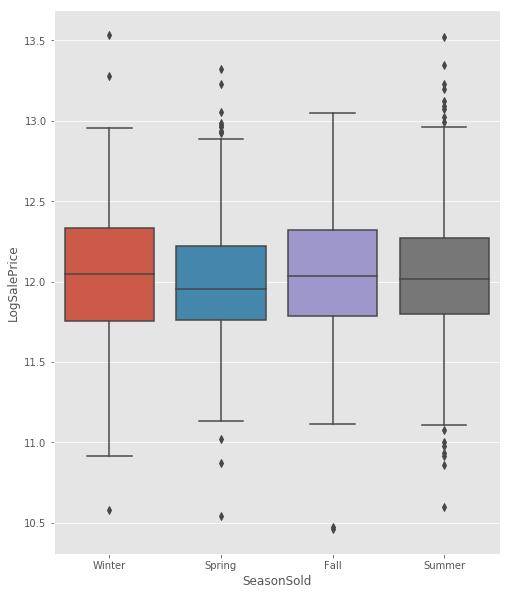

In [77]:
# MoSold
plt.figure(figsize=(8, 10))
print(X['MoSold'].value_counts())
X['SeasonSold'] = 'None'

#sns.scatterplot(y=y, x=X['MoSold'])
X.loc[X['MoSold'].isin(['1', '2', '12']), 'SeasonSold' ] = 'Winter' 
X.loc[X['MoSold'].isin(['3', '4', '5']), 'SeasonSold' ] ='Spring'
X.loc[X['MoSold'].isin(['6', '7', '8']), 'SeasonSold' ] = 'Summer'
X.loc[X['MoSold'].isin(['9', '10', '11']), 'SeasonSold' ] = 'Fall'
print(X['SeasonSold'].value_counts())
sns.boxplot(y=y, x=X['SeasonSold'])
# not clear if season would be a meaningful predictor

In [57]:
print(check_catvar_vs_y(xy, 'MSZoning', ['RL','RM','RH','FV','C (all)']), '\n')
print(check_catvar_vs_y(xyt, 'MSZoning', ['RL','RM','RH','FV','C (all)'], False))
# process: combine 'RM','RH' to 'RMH'

         MSZoning  LogSalePrice
RL         1149.0     12.085939
RM          218.0     11.692893
RH           16.0     11.749840
FV           65.0     12.246616
C (all)      10.0     11.118259 

         MSZoning
RL           1115
RM            245
RH             10
FV             74
C (all)        15


In [58]:
print(check_catvar_vs_y(xy, 'SaleType', ['WD','New','COD','ConLD','ConLw','ConLI','CWD','Oth','Con']), '\n')
print(check_catvar_vs_y(xyt, 'SaleType', ['WD','New','COD','ConLD','ConLw','ConLI','CWD','Oth','Con'], False))
# new categories: 'WD', 'New', 'Oth'
# decided to drop

       SaleType  LogSalePrice
WD       1267.0     11.991061
New       120.0     12.466114
COD        43.0     11.827437
ConLD       9.0     11.773000
ConLw       5.0     11.769706
ConLI       5.0     12.044878
CWD         4.0     12.198344
Oth         3.0     11.675295
Con         2.0     12.483911 

       SaleType
WD         1259
New         117
COD          44
ConLD        17
ConLw         3
ConLI         4
CWD           8
Oth           4
Con           3


In [60]:
print(check_catvar_vs_convar(xy, 'GarageCars', 'GarageArea', [0,1,2,3,4]), '\n')
print(check_catvar_vs_y(xy, 'GarageCars', [0,1,2,3,4]), '\n')
print(check_catvar_vs_convar(xyt, 'GarageCars', 'GarageArea', [0,1,2,3,4,5],False))
# convert to categorical, new categories for 'GarageCars': 0,1,2,3+

   GarageCars  GarageArea
0        81.0    0.000000
1       369.0  300.517615
2       823.0  518.705954
3       180.0  811.172222
4         5.0  890.400000 

   GarageCars  LogSalePrice
0        81.0     11.491874
1       369.0     11.731868
2       823.0     12.083736
3       180.0     12.586128
4         5.0     12.137198 

   GarageCars
0          77
1         407
2         770
3         193
4          11
5           1


In [61]:
#print(pd.DataFrame(xy['GarageType'].value_counts()).T)
# print(pd.DataFrame(xyt['GarageType'].value_counts()).T)
print(check_catvar_vs_y(xy, 'GarageType', ['Attchd' , 'Detchd',  'BuiltIn',  'None',  'Basment',  'CarPort',  '2Types']), '\n')
print(check_catvar_vs_y(xyt, 'GarageType', ['Attchd' , 'Detchd',  'BuiltIn',  'None',  'Basment',  'CarPort',  '2Types'], False) )
# new categories: 'Attchd_BuiltIn', 'Other'

            GarageType  LogSalePrice
GarageType                          
Attchd           869.0     12.160982
Detchd           387.0     11.765643
BuiltIn           87.0     12.377771
None              81.0     11.491874
Basment           19.0     11.916440
CarPort            9.0     11.587994
2Types             6.0     11.899157 

         GarageType
Attchd          853
Detchd          392
BuiltIn          98
None             76
Basment          17
CarPort           6
2Types           17


In [59]:
print(check_catvar_vs_y(xy, 'GarageCond',['Ex', 'Gd', 'TA', 'Fa', 'Po', 'None']), '\n')
print(check_catvar_vs_y(xyt, 'GarageCond',['Ex', 'Gd', 'TA', 'Fa', 'Po', 'None'], False))
# drop 

      GarageCond  LogSalePrice
Ex           2.0     11.727638
Gd           9.0     12.050615
TA        1324.0     12.070507
Fa          35.0     11.596881
Po           7.0     11.572878
None        81.0     11.491874 

      GarageCond
Ex             1
Gd             6
TA          1328
Fa            39
Po             7
None          78


In [81]:
# print(pd.DataFrame(xy['GarageQual'].value_counts()).T)
# print(pd.DataFrame(xyt['GarageQual'].value_counts()).T)
print(check_catvar_vs_y(xy, 'GarageQual', ['None','Po', 'Fa', 'TA' , 'Gd','Ex']), '\n')
print(check_catvar_vs_y(xyt, 'GarageQual', ['None','Po', 'Fa', 'TA' , 'Gd'],False), '\n')
# combine: new categories: 'None', 'Po_Fa', 'TA', 'Gd_Ex'

      GarageQual  LogSalePrice
None        81.0     11.491874
Po           3.0     11.472494
Fa          48.0     11.674845
TA        1309.0     12.068560
Gd          14.0     12.220068
Ex           3.0     12.175449 

      GarageQual
None          78
Po             2
Fa            76
TA          1293
Gd            10 



In [80]:
print(pd.DataFrame(xy['GarageCond'].value_counts()).T)
print(pd.DataFrame(xyt['GarageCond'].value_counts()).T)
print(check_catvar_vs_y(xy, 'GarageCond', ['None','Po', 'Fa', 'TA' , 'Gd','Ex']), '\n')
print(check_catvar_vs_y(xyt, 'GarageCond', ['None','Po', 'Fa', 'TA' , 'Gd', 'Ex'],False), '\n')
# drop: highly correlated with GarageQual, similar FI ranking in tree models, GarageQual vs. y better ordinality

              TA  None  Fa  Gd  Po  Ex
GarageCond  1324    81  35   9   7   2
              TA  None  Fa  Po  Gd  Ex
GarageCond  1328    78  39   7   6   1
      GarageCond  LogSalePrice
None        81.0     11.491874
Po           7.0     11.572878
Fa          35.0     11.596881
TA        1324.0     12.070507
Gd           9.0     12.050615
Ex           2.0     11.727638 

      GarageCond
None          78
Po             7
Fa            39
TA          1328
Gd             6
Ex             1 



In [78]:
pd.crosstab(xy['GarageQual'],xy['GarageCond'])

GarageCond,Ex,Fa,Gd,None,Po,TA
GarageQual,,,,,,
Ex,2,0,0,0,0,1
Fa,0,20,0,0,4,24
Gd,0,0,4,0,0,10
None,0,0,0,81,0,0
Po,0,0,0,0,3,0
TA,0,15,5,0,0,1289


In [83]:
#print(pd.DataFrame(xy['GarageFinish'].value_counts()).T)
#print(pd.DataFrame(xyt['GarageFinish'].value_counts()).T)
print(check_catvar_vs_y(xy, 'GarageFinish', ['None','Unf' , 'RFn', 'Fin']), '\n')
print(check_catvar_vs_y(xyt, 'GarageFinish', ['None','Unf' , 'RFn', 'Fin'],False), '\n')
# do nothing

      GarageFinish  LogSalePrice
None          81.0     11.491874
Unf          605.0     11.818974
RFn          422.0     12.172672
Fin          350.0     12.322330 

      GarageFinish
None            78
Unf            625
RFn            389
Fin            367 



In [84]:
pd.crosstab(xy['GarageQual'],xy['GarageFinish'])

GarageFinish,Fin,None,RFn,Unf
GarageQual,,,,
Ex,1,0,0,2
Fa,1,0,0,47
Gd,2,0,7,5
None,0,81,0,0
Po,0,0,0,3
TA,346,0,415,548


In [68]:
#print(pd.DataFrame(xy['SaleCondition'].value_counts()).T)
#print(pd.DataFrame(xyt['SaleCondition'].value_counts()).T)
# print(check_catvar_vs_y(xy, 'SaleCondition', ['Normal',  'Partial',  'Abnorml',  'Family',  'Alloca',  'AdjLand']), '\n')
print(xy[ xy['SaleCondition'] == "Partial" ].SaleType.value_counts()) # New construction almost completely captured by SaleType
print(cramers_v(xy['SaleCondition'], xy['SaleType']))
pd.crosstab(xy['SaleCondition'], xy['SaleType'])

New      120
WD         2
ConLD      1
Name: SaleType, dtype: int64
SaleType       COD  CWD  Con  ConLD  ConLI  ConLw  New  Oth    WD
SaleCondition                                                    
Abnorml         24    1    0      2      1      0    0    3    70
AdjLand          0    0    0      0      0      0    0    0     4
Alloca           0    0    0      0      0      0    0    0    12
Family           0    1    0      0      0      0    0    0    19
Normal          19    2    2      6      4      5    0    0  1160
Partial          0    0    0      1      0      0  120    0     2
0.47073183765888016


SaleType,COD,CWD,Con,ConLD,ConLI,ConLw,New,Oth,WD
SaleCondition,,,,,,,,,
Abnorml,24,1,0,2,1,0,0,3,70
AdjLand,0,0,0,0,0,0,0,0,4
Alloca,0,0,0,0,0,0,0,0,12
Family,0,1,0,0,0,0,0,0,19
Normal,19,2,2,6,4,5,0,0,1160
Partial,0,0,0,1,0,0,120,0,2


In [41]:
#pd.DataFrame(xy['BsmtFinType1'].value_counts()).T
print(check_catvar_vs_y(xy, 'BsmtFinType1', ['Unf','GLQ','ALQ','BLQ','Rec','LwQ','None']), '\n')

              BsmtFinType1  LogSalePrice
BsmtFinType1                            
Unf                  430.0     11.963998
GLQ                  416.0     12.303125
ALQ                  220.0     11.953313
BLQ                  148.0     11.867634
Rec                  133.0     11.852846
LwQ                   74.0     11.881354
None                  37.0     11.529680 



In [87]:
# based on height of basement
#print(pd.DataFrame(xy['BsmtQual'].value_counts()).T)
#print(pd.DataFrame(xyt['BsmtQual'].value_counts()).T)
print(check_catvar_vs_y(xy, 'BsmtQual', ['None','Fa', 'TA' , 'Gd','Ex']), '\n')
print(check_catvar_vs_y(xyt, 'BsmtQual', ['None','Fa', 'TA' , 'Gd', 'Ex'],False), '\n')

      BsmtQual  LogSalePrice
None      37.0     11.529680
Fa        35.0     11.617600
TA       649.0     11.810855
Gd       618.0     12.179882
Ex       119.0     12.650235 

      BsmtQual
None        44
Fa          53
TA         634
Gd         591
Ex         137 



In [92]:
#print(pd.DataFrame(xy['BsmtCond'].value_counts()).T)
#print(pd.DataFrame(xyt['BsmtCond'].value_counts()).T)
print(check_catvar_vs_y(xy, 'BsmtCond', ['None','Po','Fa', 'TA' , 'Gd']), '\n')
print(check_catvar_vs_y(xyt, 'BsmtCond', ['None','Po','Fa', 'TA' , 'Gd'],False), '\n')


      BsmtCond  LogSalePrice
None      37.0     11.529680
Po         2.0     11.065539
Fa        45.0     11.648864
TA      1309.0     12.042596
Gd        65.0     12.220279 

      BsmtCond
None        45
Po           3
Fa          59
TA        1295
Gd          57 



In [93]:
pd.crosstab(xy['BsmtCond'],xy['BsmtQual'])

BsmtQual,Ex,Fa,Gd,None,TA
BsmtCond,,,,,
Fa,0,8,2,0,35
Gd,11,0,36,0,18
None,0,0,0,37,0
Po,0,2,0,0,0
TA,108,25,580,0,596


In [126]:
bvars = ['BsmtQual', 'BsmtExposure', 'BsmtFinType1','BsmtFinType2','BsmtCond']
for i, vi in enumerate(bvars):
    for vj in bvars[(i+1):]:
        print(vi, vj, cramers_v(xy[vi], xy[vj]))

BsmtQual BsmtExposure 0.519921990397435
BsmtQual BsmtFinType1 0.5762597416336843
BsmtQual BsmtFinType2 0.4999834506841007
BsmtQual BsmtCond 0.52678467697144
BsmtExposure BsmtFinType1 0.5211032930093417
BsmtExposure BsmtFinType2 0.4906948855026973
BsmtExposure BsmtCond 0.4950545265720407
BsmtFinType1 BsmtFinType2 0.44650098443076175
BsmtFinType1 BsmtCond 0.5069646552368653
BsmtFinType2 BsmtCond 0.49444114521958293


In [97]:
# print(pd.DataFrame(xy['BldgType'].value_counts()).T)
# print(pd.DataFrame(xyt['BldgType'].value_counts()).T)
print(check_catvar_vs_y(xy, 'BldgType', ['1Fam','2fmCon','Duplex', 'TwnhsE' , 'Twnhs']), '\n')
print(check_catvar_vs_y(xyt, 'BldgType', ['1Fam','2fmCon','Duplex', 'TwnhsE' , 'Twnhs'],False), '\n')

        BldgType  LogSalePrice
1Fam      1218.0     12.047500
2fmCon      31.0     11.725353
Duplex      52.0     11.780920
TwnhsE     114.0     12.059451
Twnhs       43.0     11.773906 

        BldgType
1Fam        1205
2fmCon        31
Duplex        57
TwnhsE       113
Twnhs         53 



In [99]:
# print(pd.DataFrame(xy['HouseStyle'].value_counts()).T)
# print(pd.DataFrame(xyt['HouseStyle'].value_counts()).T)
print(check_catvar_vs_y(xy, 'HouseStyle', ['1Story','2Story', '1.5Fin', 'SLvl', 'SFoyer', '1.5Unf', '2.5Unf', '2.5Fin']), '\n')
print(check_catvar_vs_y(xyt, 'HouseStyle', ['1Story','2Story', '1.5Fin', 'SLvl', 'SFoyer', '1.5Unf', '2.5Unf'],False), '\n')

            HouseStyle  LogSalePrice
HouseStyle                          
1Story           726.0     11.993683
2Story           443.0     12.183263
1.5Fin           154.0     11.813528
SLvl              65.0     12.002153
SFoyer            37.0     11.786479
1.5Unf            14.0     11.595027
2.5Unf            11.0     11.908751
2.5Fin             8.0     12.194451 

        HouseStyle
1Story         745
2Story         427
1.5Fin         160
SLvl            63
SFoyer          46
1.5Unf           5
2.5Unf          13 



In [100]:
pd.crosstab(xy['HouseStyle'], xy['BldgType'])
# do nothing

BldgType,1Fam,2fmCon,Duplex,Twnhs,TwnhsE
HouseStyle,,,,,
1.5Fin,142,8,4,0,0
1.5Unf,13,1,0,0,0
1Story,607,7,29,5,78
2.5Fin,7,1,0,0,0
2.5Unf,9,2,0,0,0
2Story,360,11,9,33,30
SFoyer,20,0,9,4,4
SLvl,60,1,1,1,2


In [101]:
pd.crosstab(xy['KitchenAbvGr'],xy['BldgType'])

BldgType,1Fam,2fmCon,Duplex,Twnhs,TwnhsE
KitchenAbvGr,,,,,
0,0,0,1,0,0
1,1212,14,7,43,114
2,5,16,44,0,0
3,1,1,0,0,0


In [102]:
pd.crosstab(xy['KitchenAbvGr'],xy['BldgType'])

BldgType,1Fam,2fmCon,Duplex,Twnhs,TwnhsE
KitchenAbvGr,,,,,
0,0,0,1,0,0
1,1212,14,7,43,114
2,5,16,44,0,0
3,1,1,0,0,0
